In [1]:
%load_ext autoreload
%autoreload 2

# Avaliação teórico-prática 3 (ATP3)

*Para questões discursivas, você pode escrever em formato Markdown/LaTeX ou, preferencialmente, incluir uma fotografia da solução do exercício.*

___
**1.** **(2 pontos)** Explique a sobre .
___

[*Resposta aqui*]

...

___
**2.** **(3 pontos)** Explique, com suas palavras, o Teorema da Convolução e sua importância no contexto de processamento de sinais.
___

[*Resposta aqui*]

...

___
**4.** **(5 pontos)** Na disciplina de Morfologia Matemática, os operadores de dilatação e erosão são considerados duais em relação aos conjuntos complementares e à reflexão:

$(A \ominus B)^C = A^C \oplus \hat{B}$

$(A \oplus B)^C = A^C \ominus \hat{B}$

Estas equações representam o princípio da dualidade na Morfologia Matemática. Sua tarefa nesta questão é demonstrar empiricamente a validade deste princípio. Para isso, você deve escrever um código Python que implemente estas operações e verifique se as igualdades acima são verdadeiras para uma imagem binária de sua escolha.
___


In [2]:
########################################################
# YOUR CODE GOES HERE.                                 #
########################################################

___
**5.** **(5 pontos)** Em Processamento de Imagens, a Morfologia Matemática e a rotulação de componentes conexas são técnicas poderosas para análise de estruturas em uma imagem. Uma aplicação interessante é a contagem de palavras em uma imagem contendo texto.

Sua tarefa nesta questão é escrever um código Python que implemente o seguinte procedimento:

1. Use técnicas de Morfologia Matemática para agrupar caracteres de uma mesma palavra imagem (utilize a imagem `text.tif`).
2. Aplique a rotulação de componentes conexas para identificar cada palavra como um componente separado.
3. Conte o número de componentes conexas, que corresponderá ao número de palavras na imagem.

Dica: Você pode usar a função `skimage.measure.label` para a rotulação de componentes conexos.

___


In [3]:
########################################################
# YOUR CODE GOES HERE.                                 #
########################################################

___
**5.** **(5 pontos)** [EXTRA] [O BID Dataset](https://github.com/ricardobnjunior/Brazilian-Identity-Document-Dataset) [1] é uma coleção de documentos de identificação Brasileiros utilizada para desenvolvimento e avaliação de técnicas para (i) Classificação de Imagens de Documentos; (ii) Segmentação de Regiões de Texto e (iii) Reconhecimento Óptico de Caracteres (OCR). Nesta atividade, você deve escolher uma imagem frontal de CNH desta base de dados e segmentar o conteúdo dos campos.

Para isso, implemente um código Python que realize as seguintes etapas:

1. Converta a imagem para escala de cinza.
2. Escolha uma técnica de binarização (thresholding) e aplique na imagem.
3. Inverta a imagem binarizada para que o fundo seja preto e o texto branco.
4. Utilize a Morfologia Matemática para detectar as caixas correspondentes aos campos de preenchimento da CNH.
5. Utilize o resultado anterior para determinar a área interna das caixas.
6. Utilize Morfologia Matemática para agrupar (lateralmente) o conteúdo interno das caixas.
7. Aplique a rotulação de componentes conexas para identificar o conteúdo interno de cada caixa.


[1] de Sá Soares, A., das Neves Junior, R. B., & Bezerra, B. L. D. (2020, November). BID Dataset: a challenge dataset for document processing tasks. In Anais Estendidos do XXXIII Conference on Graphics, Patterns and Images (pp. 143-146). SBC.
___


In [4]:
########################################################
# YOUR CODE GOES HERE.                                 #
########################################################

0.0 0.7755855366066812


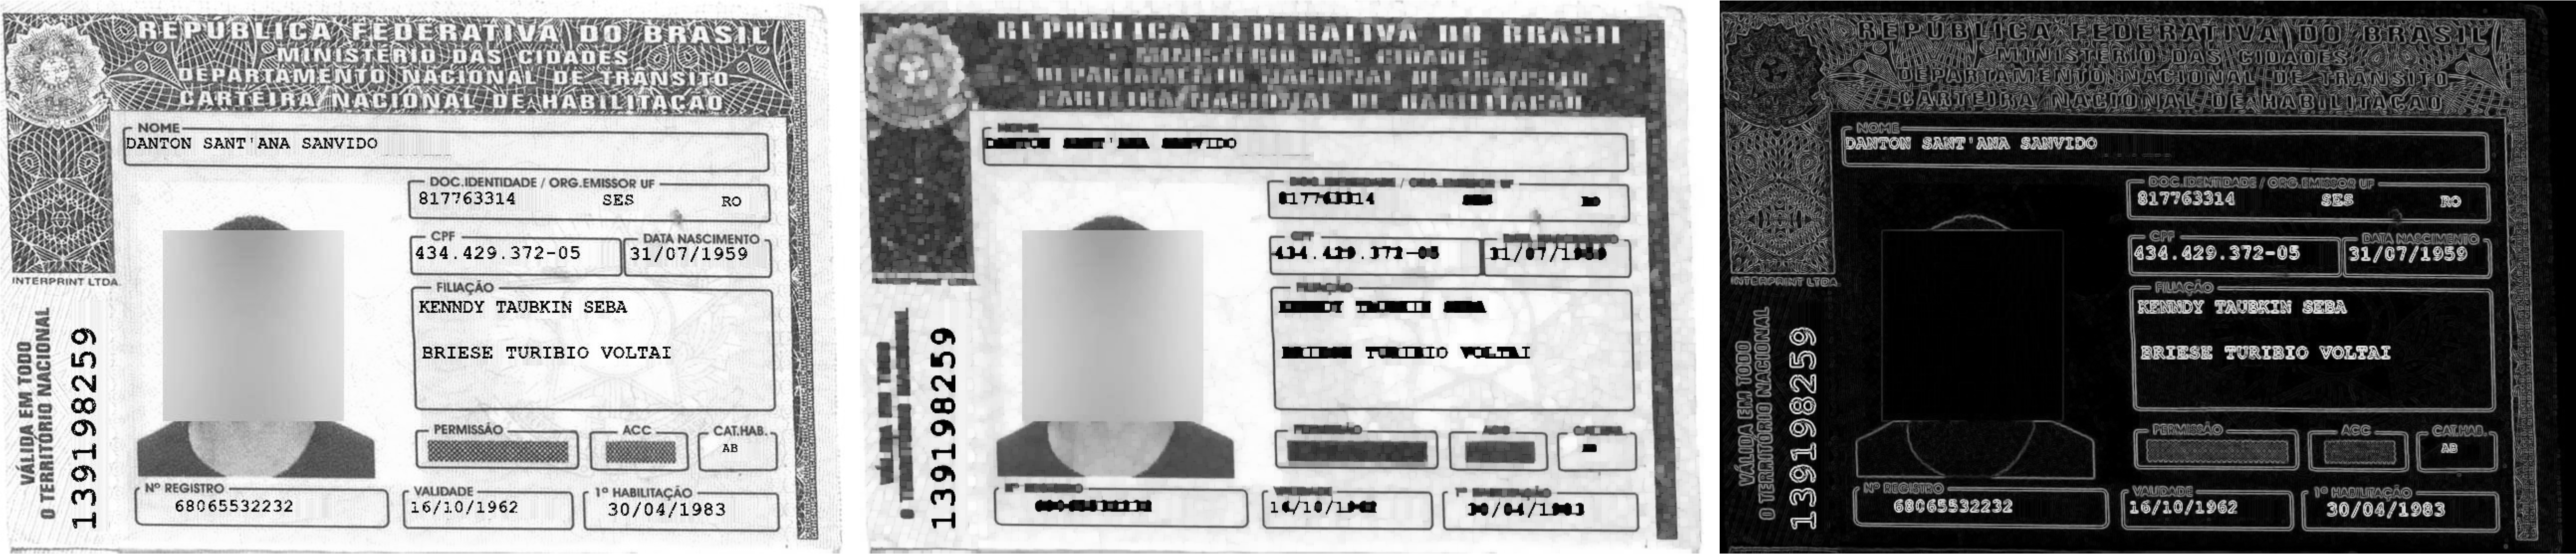

In [5]:
import numpy as np
from skimage import io
from skimage.color import rgb2gray
from skimage.filters import threshold_sauvola
from skimage.morphology import binary_opening, binary_closing, closing, disk, square, opening
from skimage.measure import label, regionprops
from skimage.segmentation import flood
import matplotlib.pyplot as plt
from chart import show_collection, show
from scipy.ndimage import correlate
from skimage.filters import roberts, prewitt, sobel


# Load the image
image_path = '../images/00003624_in.jpg'
image = io.imread(image_path)

# Dimensions of the image
h, w, _ = image.shape

# Convert the image to grayscale
gray_image = rgb2gray(image)

# Morphology-based gradient
selem = square(5)
gradient = gray_image - opening(gray_image, selem)
gradient = sobel(gray_image)
print(gradient.min(), gradient.max())

show_collection([gray_image, opening(gray_image, selem), gradient], cmap='gray', scale=0.2)

In [9]:
import numpy as np
from skimage import io
from skimage.color import rgb2gray
from skimage.filters import threshold_sauvola
from skimage.morphology import binary_opening, binary_closing
from skimage.measure import label, regionprops
from skimage.segmentation import flood
import matplotlib.pyplot as plt
from chart import show_collection


# Load the image
image_path = '../images/00003624_in.jpg'
image = io.imread(image_path)

# Dimensions of the image
h, w, _ = image.shape

# Convert the image to grayscale
gray_image = rgb2gray(image)

# Threshold the image using the Sauvola method and invert it
threshold = threshold_sauvola(gray_image, window_size=25)
binary_image = gray_image < threshold

# Remove from binary image the largest region
# - Closing with a square structuring element
selem = np.ones((5, 5))
closed_image = binary_closing(binary_image, selem)

# - Connected component labeling
label_image = label(closed_image)
regions = regionprops(label_image)

# - Get the largest connected component
max_area = 0
max_region = None
for region in regions:
    if region.area > max_area:
        max_area = region.area
        max_region = region

# - Removal
removed_largest_image = binary_image.copy()
removed_largest_image[label_image == max_region.label] = 0

# Filtering out thick areas by top-hat transform
# - Opening with a square structuring element
selem = np.ones((10, 10))
seed_image = binary_opening(removed_largest_image, selem)

# - Region growing from the seeds
label_image = label(seed_image)
regions = regionprops(label_image)
seeds = [tuple(region.coords[0, :]) for region in regions]
masks = [flood(removed_largest_image, seed) for seed in seeds]

# - Filtering
filtered_thick_image = removed_largest_image ^ np.logical_or.reduce(masks)

# Filtering short vertical lines
selem = np.ones((15, 1))
seed_image = binary_opening(filtered_thick_image, selem)

# - Region growing from the seeds
label_image = label(seed_image)
regions = regionprops(label_image)
seeds = [tuple(region.coords[0, :]) for region in regions]
masks = [flood(filtered_thick_image, seed) for seed in seeds]

# - Filtering
filtered_short_vlines_image = np.logical_or.reduce(masks)

# Filtering short horizontal lines
selem = np.ones((1, 40))
seed_image = binary_opening(filtered_short_vlines_image, selem)

# - Region growing from the seeds
label_image = label(seed_image)
regions = regionprops(label_image)
seeds = [tuple(region.coords[0, :]) for region in regions]
masks = [flood(filtered_short_vlines_image, seed) for seed in seeds]

# - Filtering
filtered_short_hlines_image = np.logical_or.reduce(masks)

# Detect fields by connected component analysis
label_image = label(filtered_short_hlines_image)
regions = regionprops(label_image)
bboxes = [(region.bbox[1], region.bbox[0], region.bbox[3]-region.bbox[1], region.bbox[2]-region.bbox[0]) for region in regions]

# # Remove small lines detected as fields
# label_image = label(field_image)
# regions = regionprops(label_image)
# heights = [region.bbox[2] - region.bbox[0] for region in regions]
# median_height = np.median(heights)
# field_image_rem = field_image.copy()
# for region in regions:
#     if region.bbox[2] - region.bbox[0] < median_height:
#         field_image_rem[label_image == region.label] = 0

# # Remove characters touching the border
# selem1 = np.ones((1, 10))
# selem2 = np.ones((10, 1))
# opened_image_x = binary_opening(field_image_rem, selem1)
# opened_image_y = binary_opening(field_image_rem, selem2)
# characters = np.logical_or(opened_image_x, opened_image_y)

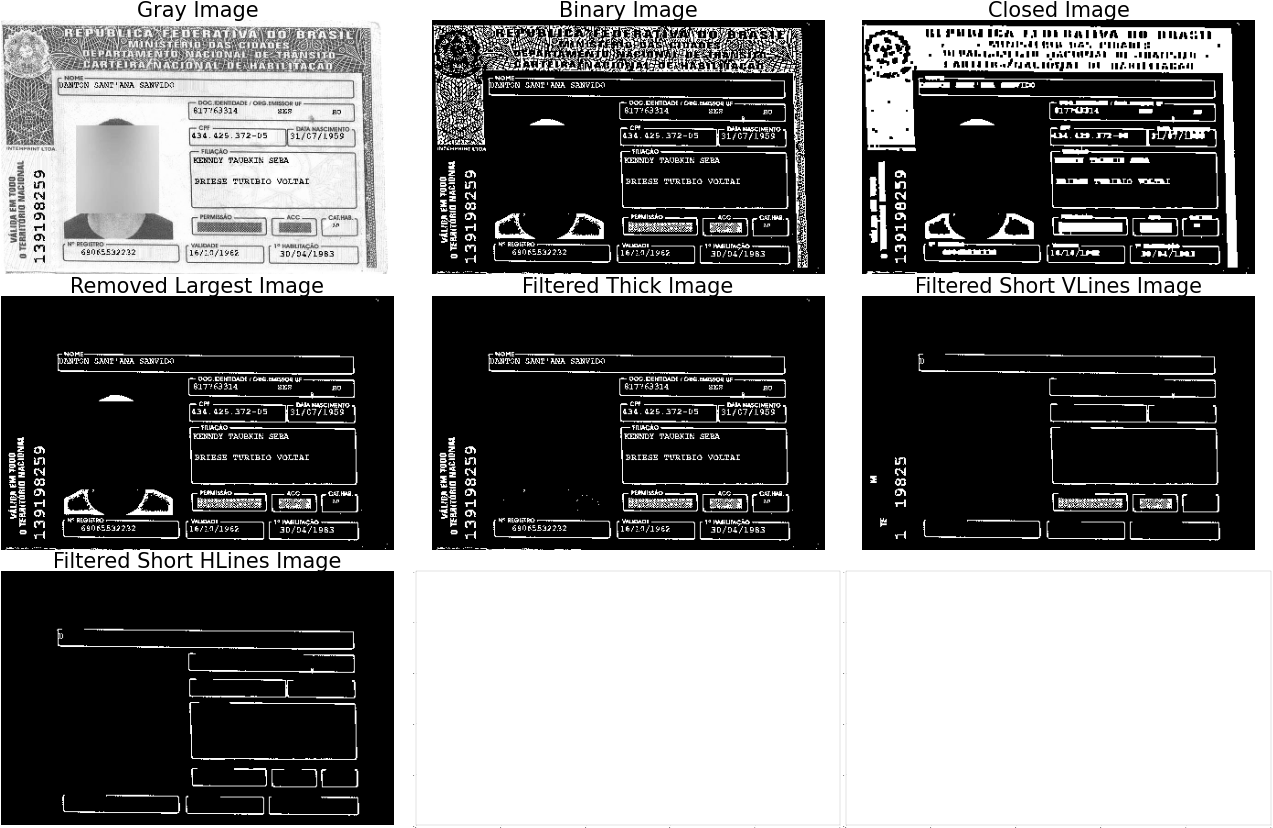

In [7]:
images = [gray_image, binary_image, closed_image, removed_largest_image, filtered_thick_image, filtered_short_vlines_image, filtered_short_hlines_image]
titles = ['Gray Image', 'Binary Image', 'Closed Image', 'Removed Largest Image', 'Filtered Thick Image', 'Filtered Short VLines Image', 'Filtered Short HLines Image']
images = [image[::2, ::2] for image in images]
show_collection(images, titles, num_cols=3, scale=0.1, cmap='gray', fontsize=15)

(-0.5, 859.5, 555.5, -0.5)

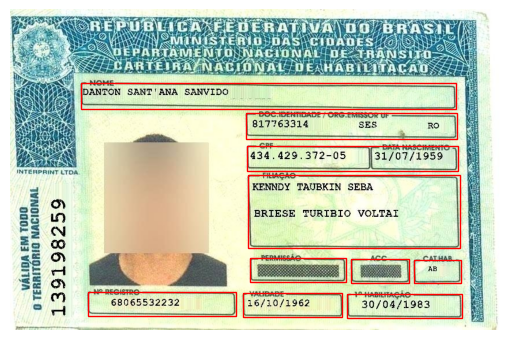

In [8]:
fig, ax = plt.subplots()
ax.imshow(image)
for bbox in bboxes:
    rect = plt.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], edgecolor='r', facecolor='none')
    ax.add_patch(rect)
plt.axis('off')